# Análisis Exploratorio de Datos: EDA Dashboards

## Tabla de Contenidos

1. [Objetivo](#1-objetivo)

2. [Consideraciones](#2-consideraciones)

3. [Análisis Exploratorio de Datos](#3-análisis-exploratorio)

    3.1. [Descripción del Dataset](#31-descripción-del-dataset)

    3.2. [Análisis por Gerencia](#32-análisis-por-gerencia)

    3.3. [Vistas por Gerencia](#33-vistas-por-gerencia)

    3.4. [Análisis por Frecuencia de Actualización](#34-análisis-por-frecuencia-de-actualización)

    3.5. [Vistas por Frecuencia de Actualización](#35-vistas-por-frecuencia-de-actualización)

    3.6. [Análisis de Usuarios con Acceso](#36-análisis-de-usuarios-con-acceso)

4. [Propuesta de Cálculo de Usabilidad](#4-propuesta-de-cálculo-de-usabilidad)

    4.1. [Factor de Frecuencia](#41-factor-de-frecuencia)

    4.2. [Total de Usuarios con Acceso](#42-total-de-usuarios-con-acceso)

    4.3. [Constante](#43-constante)

    4.4. [Lógica de la Fórmula de Umbral de Usabilidad](#44-lógica-de-la-fórmula-de-umbral-de-usabilidad)

5. [Aplicación de la Fórmula de Usabilidad](#5-aplicación-de-la-fórmula-de-usabilidad)

    5.1. [Creación de Umbral de Usabilidad por Dashboard](#51-creación-de-umbral-de-usabilidad-por-dashboard)

    5.2. [Análisis de Variabilidad por Constantes](#52-análisis-de-variabilidad-por-constantes)

    5.3. [Cálculo del Information Value](#53-cálculo-de-information-value)

    5.3.1. [Frecuencia de Actualización](#531-frecuencia-de-actualización)

    5.3.2. [Total de Usuarios con Acceso](#532-total-de-usuarios-con-acceso)

    5.3.3. [Es Chapter](#533-es-chapter)

    5.3.4. [Fuente de Datos - GCP](#534-fuente-de-datos---gcp)


6. [Conclusiones y Recomentaciones](#6-conclusiones-y-recomendaciones)

## 1. Objetivo

El objetivo de este análisis es poder definir los umbrales de uso para determinar el nivel de usabilidad de los dashboards publicados en el Centro de Servicios Compartidos de Alicorp

## 2. Consideraciones

- Para este análisis se están tomando los dashboards publicados en Power BI Viewer de las Gerencias del CSC (Administración, Tesorería Operativa y PTP, Record to Report (RTR), Excelencia Operativa, Créditos BO y Cobranzas y Gerencia de Servicios al Colaborador)
- Se está incluyendo el análisis a los dashboards publicados de la Gerencia de Operación Tributaria (Actualmente fuera del CSC)
- Se toman todas las vistas de los primeros seis (6) meses del 2025
- Se excluyen de las vistas a los usuarios del equipo de Analytics CSC (Diana Acosta, Katherine Bustamante, Angelo Perales y Juan José Palomino) debido a que han sido usuarios constructores en una gran parte de los dashboards, lo que puede distorsionar el uso real.
- Sin embargo, sí se consideran las vistas de Analytics CSC en los Dashboards publicados en el Workspace **CSC_WORK_ANALYTICS**.
- Actualmente, según el Activity Report (https://bi.alicorp.com.pe/reports/457), contamos con 59 dashboards publicados en Power BI Viewer. No obstante, el dashboard con ID 767 - **CSC - ADM - Proyectos de infraestructura** (https://bi.alicorp.com.pe/reports/767) no cuenta con vistas que no sean de usuarios que no sean de Analytics CSC, por lo que no se toma en consideración.

## 3. Análisis Exploratorio

In [79]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scorecardpy as sc
import warnings 
warnings.filterwarnings("ignore")

In [80]:
ruta_actual = os.getcwd()
ruta_archivo = os.path.join(ruta_actual,'data','dashboards_csc.xlsx')

### 3.1. Descripción del Dataset

In [81]:
df = pd.read_excel(ruta_archivo)
df.head()

,Gerencia,Dashboard,Es Activo,Descripcion,Usuario,Usuarios,Usuarios Activos,% Usuarios Activos,Promedio Mensual de Vistas,Frecuencia,...,GerenciaResponsable,nombre_workspace,ID_PowerBIViewer,enero,febrero,marzo,abril,mayo,junio,julio
0,ADM,CSC_ADM_Servicio de Taxis,1.0,Dashboard que brinda detalles del servicio y g...,NaN,338,75,0.22,26,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,437,41.0,85.0,37.0,14.0,32.0,31,5
1,ADM,CSC_Administración,1.0,Dsashboard utilizado para realizar seguimiento...,Juan Palomino,15,7,0.47,6,Mensual,...,Gerencia Corporativa de Administración,CSC KPIs SLA Indicadores,469,11.0,4.0,12.0,1.0,3.0,3,1
2,ADM,CSC_ADM_Control presupuestal,1.0,"Alcance: Visibilidad del presupuesto, comprome...",Juan Palomino,21,11,0.52,19,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,504,45.0,4.0,4.0,45.0,39.0,9,13
3,ADM,CSC_SLA_Administración,1.0,Dashboard indicadores procesos y Productividad,NaN,15,10,0.67,37,Mensual,...,Gerencia Corporativa de Administración,CSC KPIs SLA Indicadores,556,29.0,8.0,54.0,33.0,89.0,69,33
4,ADM,CSC_EXC_Predios,1.0,NaN,NaN,7,4,0.57,6,Mensual,...,Gerencia Corporativa de Administración,CSC_ADM_Workpace,646,7.0,1.0,2.0,3.0,1.0,16,11


In [82]:
# Tamaño del Dataset
df.shape

(58, 28)

### 3.2. Análisis por Gerencia

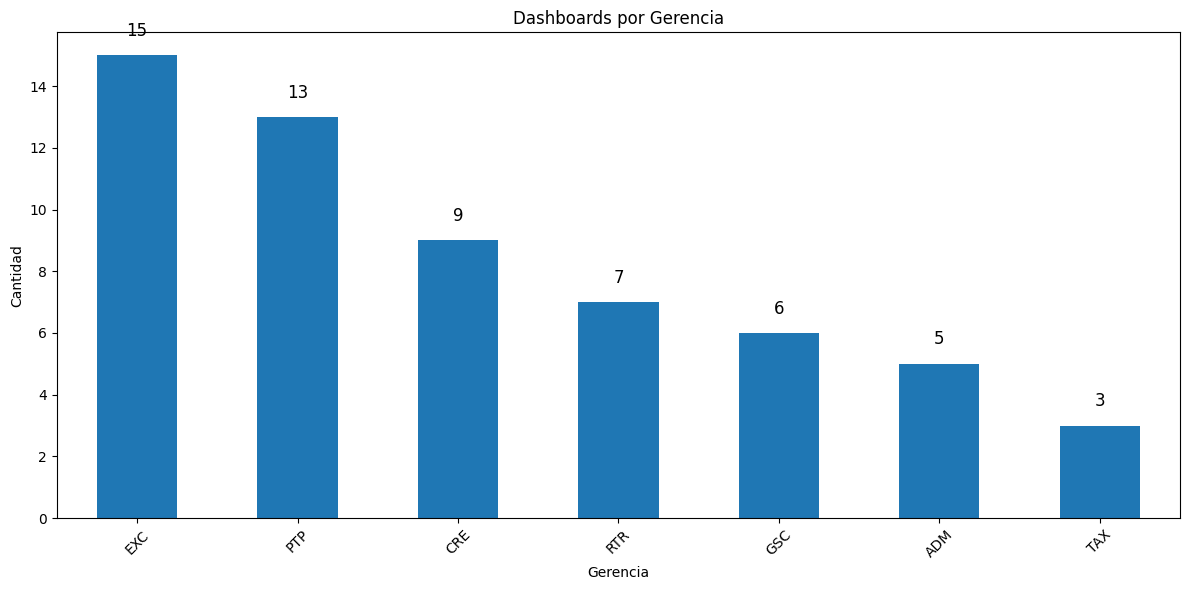

In [83]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_gerencia = df.groupby(['Gerencia']).size().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_gerencia.plot(kind='bar', ax=ax)

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_gerencia.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Dashboards por Gerencia')
ax.set_ylabel('Cantidad')
ax.set_xlabel('Gerencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.3. Vistas por Gerencia

In [84]:
meses = ['enero','febrero','marzo','abril','mayo','junio']

# Suma ignorando NaN
df['total_vistas_1_sem_2025'] = df[meses].sum(axis=1, skipna=True).round(0)

# Promedio de vistas de los primeros 6 meses del 2025. No se cuentan los valores NaN
df['prom_vistas_1_sem_2025'] = (df['total_vistas_1_sem_2025'] / df[meses].notna().sum(axis=1)).round(0)

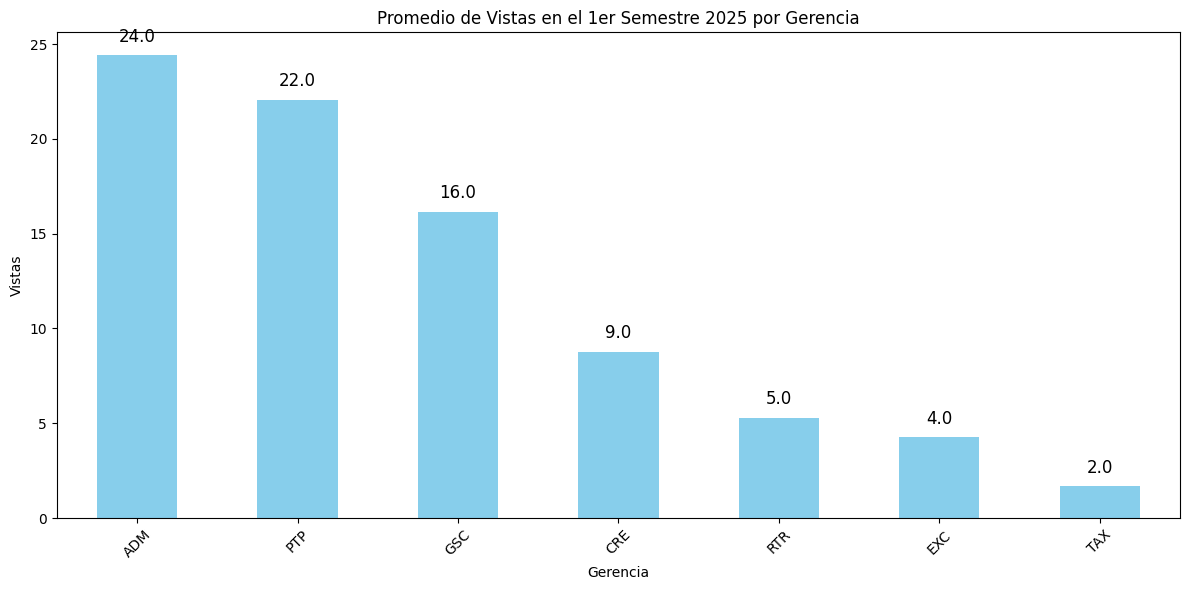

In [85]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_vistas = df.groupby(['Gerencia'])['prom_vistas_1_sem_2025'].mean().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_vistas.plot(kind='bar', ax=ax, color='skyblue')

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_vistas.values):
    ax.text(i, value + 0.5, str(round(float(value),0)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Promedio de Vistas en el 1er Semestre 2025 por Gerencia')
ax.set_ylabel('Vistas')
ax.set_xlabel('Gerencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

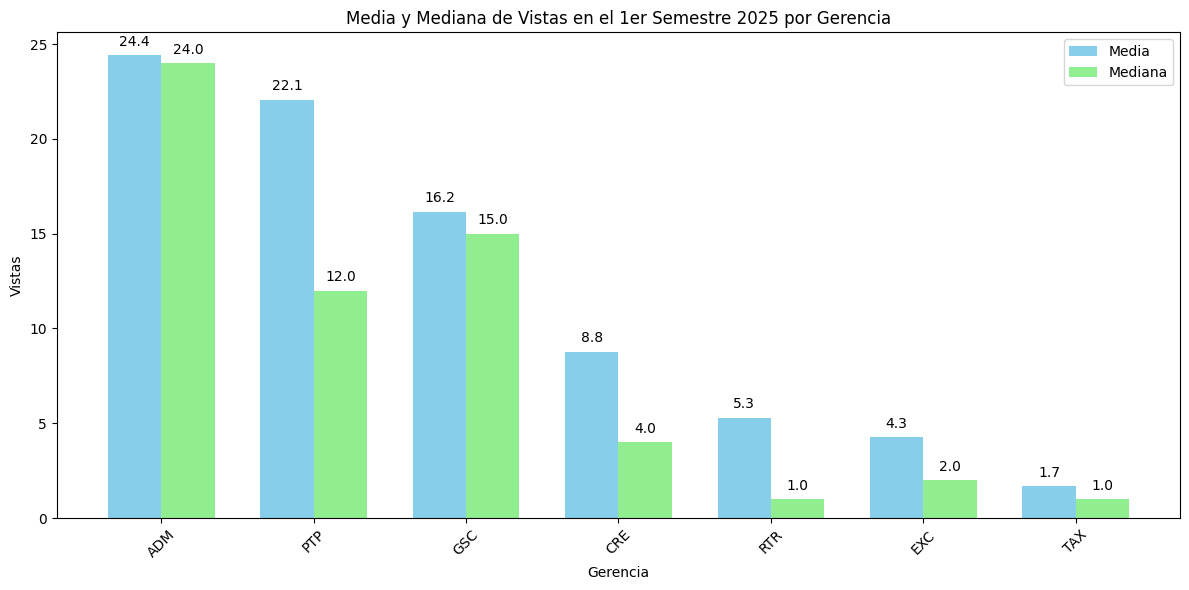

In [86]:
# Calcular media y mediana por Gerencia
media_por_gerencia = df.groupby('Gerencia')['prom_vistas_1_sem_2025'].mean().sort_values(ascending=False)
mediana_por_gerencia = df.groupby('Gerencia')['prom_vistas_1_sem_2025'].median()

# Asegurar que están en el mismo orden
gerencias = media_por_gerencia.index
media_vals = media_por_gerencia.values
mediana_vals = mediana_por_gerencia[gerencias].values

# Posiciones para las barras
x = np.arange(len(gerencias))  # posiciones de cada gerencia
width = 0.35  # ancho de cada barra

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, media_vals, width, label='Media', color='skyblue')
bars2 = ax.bar(x + width/2, mediana_vals, width, label='Mediana', color='lightgreen')

# Añadir etiquetas encima de cada barra
for i in range(len(x)):
    ax.text(x[i] - width/2, media_vals[i] + 0.5, f'{media_vals[i]:.1f}', ha='center', fontsize=10)
    ax.text(x[i] + width/2, mediana_vals[i] + 0.5, f'{mediana_vals[i]:.1f}', ha='center', fontsize=10)

# Ajustes del gráfico
ax.set_title('Media y Mediana de Vistas en el 1er Semestre 2025 por Gerencia')
ax.set_ylabel('Vistas')
ax.set_xlabel('Gerencia')
ax.set_xticks(x)
ax.set_xticklabels(gerencias, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

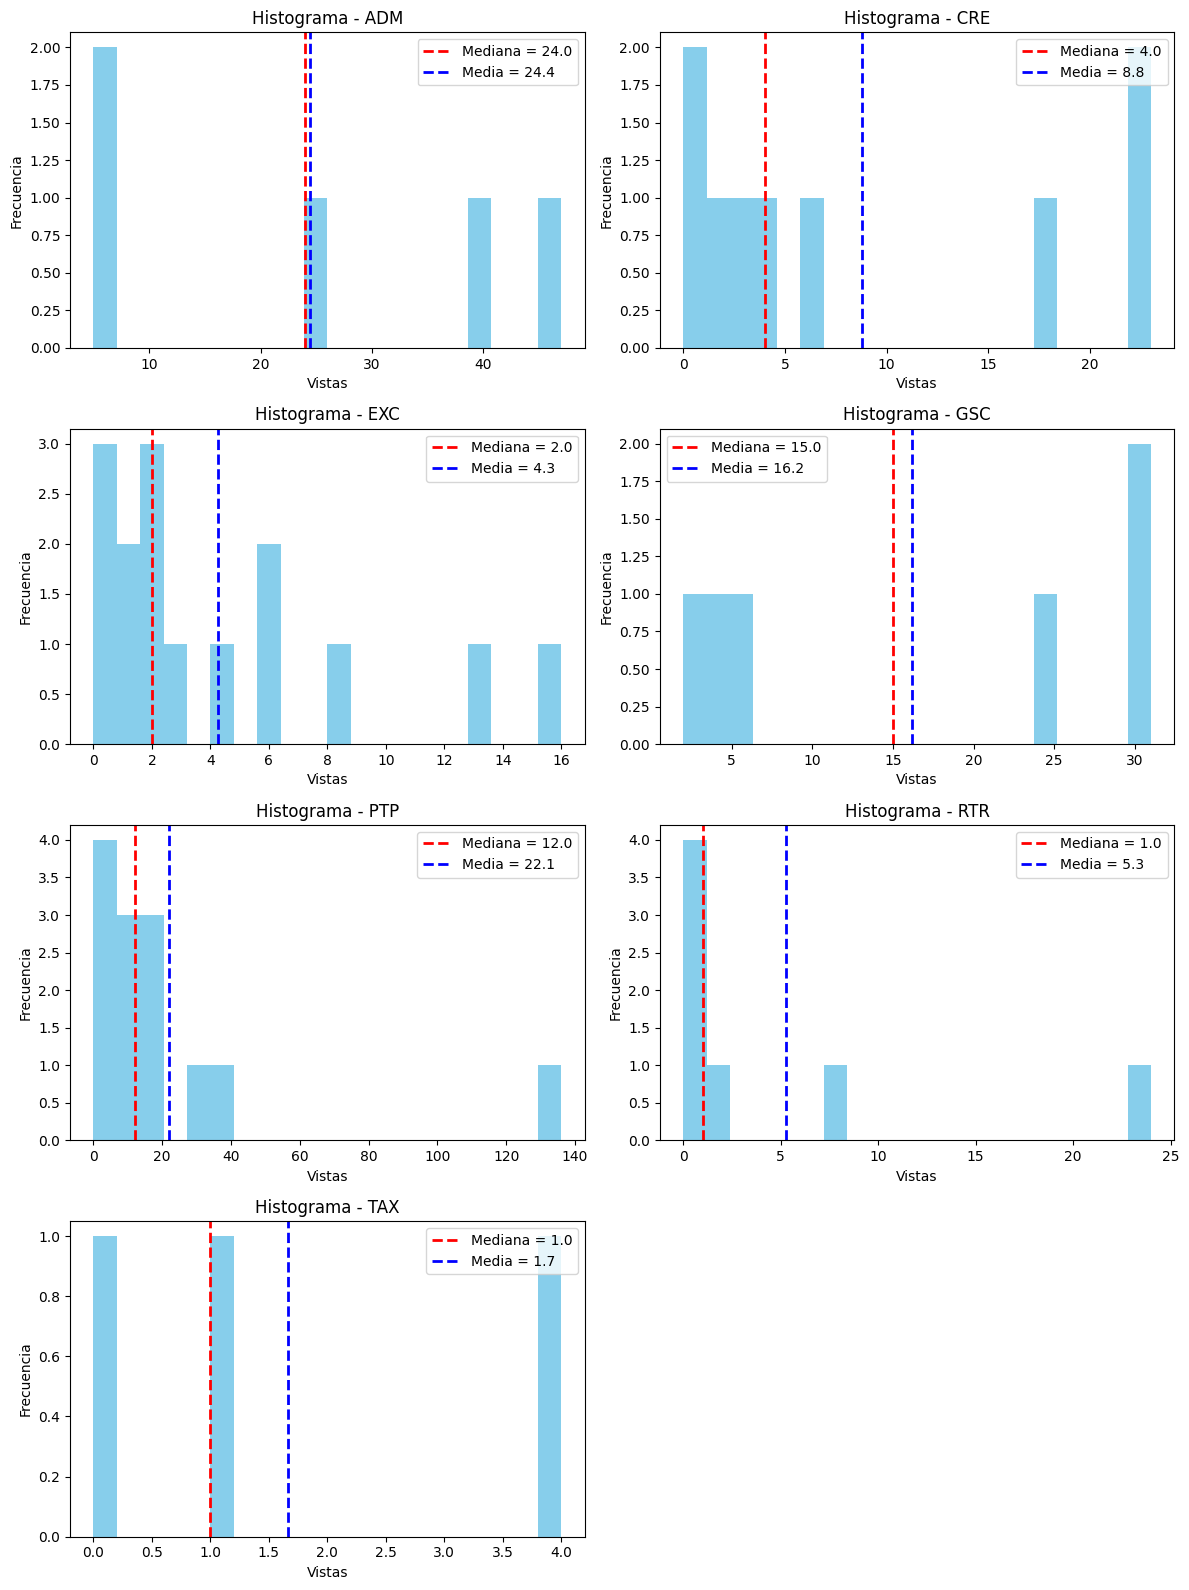

In [87]:
# Obtener lista única de gerencias
gerencias = df['Gerencia'].unique()
num_gerencias = len(gerencias)

# Configurar subplots: 2 columnas, suficientes filas
cols = 2
rows = (num_gerencias + 1) // cols  # redondear hacia arriba, ya que son 7 gerencias

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()  # para acceder como una lista plana

# Crear un histograma por gerencia
for i, gerencia in enumerate(gerencias):
    ax = axes[i]
    datos = df[df['Gerencia'] == gerencia]['prom_vistas_1_sem_2025']
    mediana_i = datos.median()
    media_i = datos.mean()

    # Configurar valores
    ax.hist(datos, bins=20, color='skyblue')
    ax.axvline(x=mediana_i,color='red',linestyle='--',linewidth=2,label=f'Mediana = {mediana_i:.1f}')
    ax.axvline(x=media_i,color='blue',linestyle='--',linewidth=2,label=f'Media = {media_i:.1f}')
    ax.set_title(f'Histograma - {gerencia}')
    ax.legend()
    ax.set_xlabel('Vistas')
    ax.set_ylabel('Frecuencia')

# Si sobran subplots vacíos (en este caso, 1), los ocultamos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

En esta gráfica se puede ver lo siguiente:

- **La Gerencia de Administración (ADM)** tiene cinco (5) dashboards que, en promedio tienen 24.4 vistas por mes. Además, vemos que la mediana tiene un valor bastante similar (24). Esto nos da a entender que los dashboards de Administración se ven de manera equilibrada.
- **La Gerencia de Tesorería Operativa y PTP (PTP)** cuenta con trece (13) dashboards los cuales, el promedio, tienen 22.1 vistas por mes. No obstante, vemos que si calculamos la mediana, el valor cae hasta 12 vistas de media por mes. Esto se ve influenciado porque PTP cuenta con el Dashboard más visto de todo el CSC (el cual es el Dashboard de Gestión de Proceso de OC-OS TI). 
- Adicionalmente, PTP tiene dashboards de SLA que actualmente no ven uso y otros dashboards construidos en una primera etapa que actualmente no ven actividad.
- **La Gerencia de Servicios al Colaborador (GSC)** cuenta con seis (6) dashboards y su media y mediana están relativamente cercanas. Lo que habla de un uso equilibrado de sus dashboards.
- **La Gerencia de Créditos BO y Cobranzas (CRE)** cuenta con nueve (9) dashboards. Sin embargo, la diferencia entre su media (8.8) y su mediana (4) es considerable. Esto nos indica que hay más dashboards publicados que actualmente no están siendo utilizados.
- **La Gerencia de Registro al Reporte (RTR)** cuenta con nueve (7) dashboards. Similar al caso de Créditos, la diferencia entre su media (8.8) y su mediana (4) es considerable. En la gráfica se evidencia que tienen dashboards con muy pocas vistas (cerca de 1 vista al mes) Esto nos indica que hay más dashboards publicados que actualmente no están siendo utilizados.
- **La Gerencia de Excelencia Operativa (EXC)** cuenta con quince (15) dashboards. Es la gerencia con más dashboards publicados en Power BI Viewer. No obstante, es la segunda gerencia con menos vistas al mes en promedio (4.3). Además, la mitad de los dashboards tiene de 2 (o menos) vistas al mes
- **La Gerencia de Operación Tributaria (TAX)** cuenta con solo tres (3) dashboards. Es la gerencia con menos vistas de todo el CSC y es la que menos vistas tiene, tanto el media (1.7) como en mediana (1), siendo que su Dashboard con más vistas en todo el primer semestre 2025 cuenta son un promedio de 4 vistas al mes.

### 3.4. Análisis por Frecuencia de Actualización

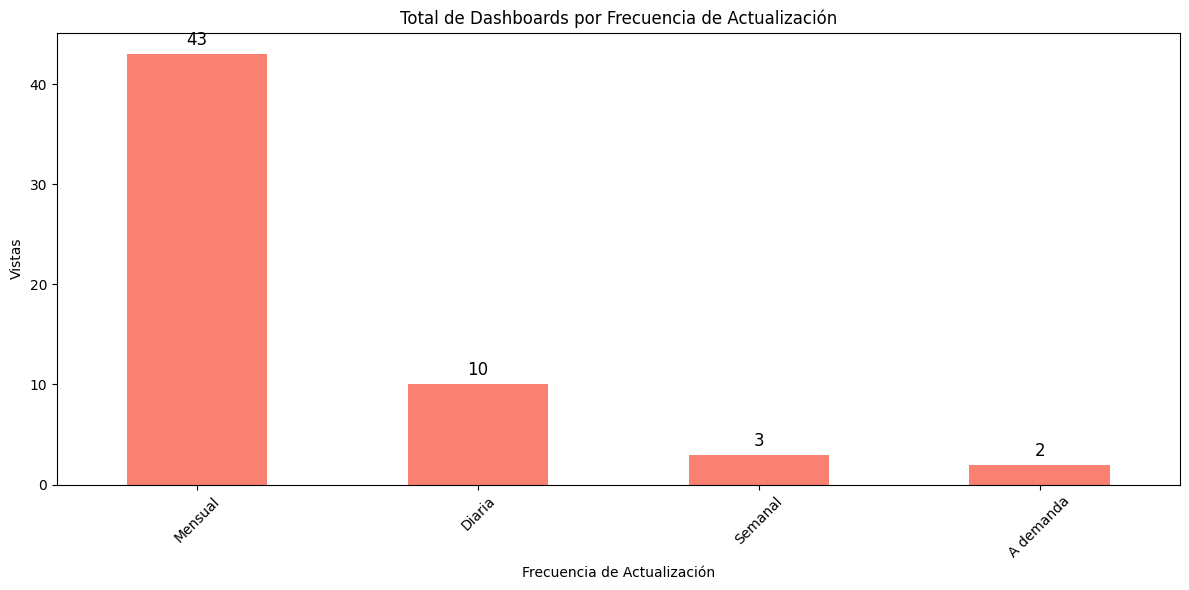

In [88]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_por_frecuencia = df.groupby(['Frecuencia']).size().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_por_frecuencia.plot(kind='bar', ax=ax, color='salmon')

# Añadir los números encima de cada barra
for i, value in enumerate(df_por_frecuencia.values):
    ax.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Total de Dashboards por Frecuencia de Actualización')
ax.set_ylabel('Vistas')
ax.set_xlabel('Frecuencia de Actualización')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

De la gráfica anterior podemos concluir que:

- La mayor cantidad de dashboards registrados se manejan de manera mensual. Esto puede explicarse debido a que la gran mayoría de indicadores se miden sobre mes cerrado.
- Por otro lado, se registraron solo dos (2) dashboard como **a demanda**. Esto se explica porque la actualización de estos dashboards dependerán del input de la Gerencia del CSC.

### 3.5. Vistas por Frecuencia de Actualización

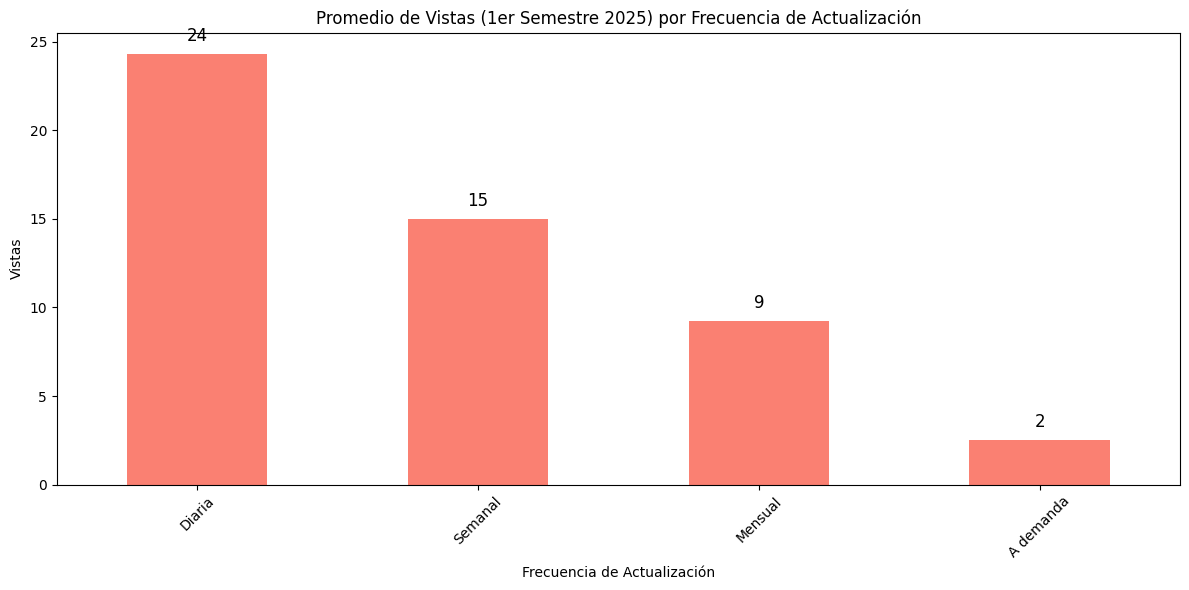

In [89]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_vistas_por_frecuencia = df.groupby(['Frecuencia'])['prom_vistas_1_sem_2025'].mean().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_vistas_por_frecuencia.plot(kind='bar', ax=ax, color='salmon')

# Añadir los números encima de cada barra
for i, value in enumerate(df_vistas_por_frecuencia.values):
    ax.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Promedio de Vistas (1er Semestre 2025) por Frecuencia de Actualización')
ax.set_ylabel('Vistas')
ax.set_xlabel('Frecuencia de Actualización')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En esta gráfica podemos notar que:
- Los Dashboards diarios tienen el mayor promedio de visualizaciones. Esto se puede explicar debido a que, a un mayor ritmo de actualización, los usuarios están al más al tanto de las actualizaciones.
- Por otro lado, los dashboards a demanda son los menos vistos (2 vistas en promedio en 6 meses). Esto se puede explicar a que la responsabilidad de actualización depende enteramente de la Gerencia.

In [90]:
total_vistas = df['prom_vistas_1_sem_2025']
total_vistas[:5]

0    40.0
1     6.0
2    24.0
3    47.0
4     5.0
Name: prom_vistas_1_sem_2025, dtype: float64

In [91]:
# Ver la mediana de vistas
mediana_vistas = np.median(total_vistas)

print('Mediana del Promedio de Vistas 2025:',mediana_vistas)

Mediana del Promedio de Vistas 2025: 4.5


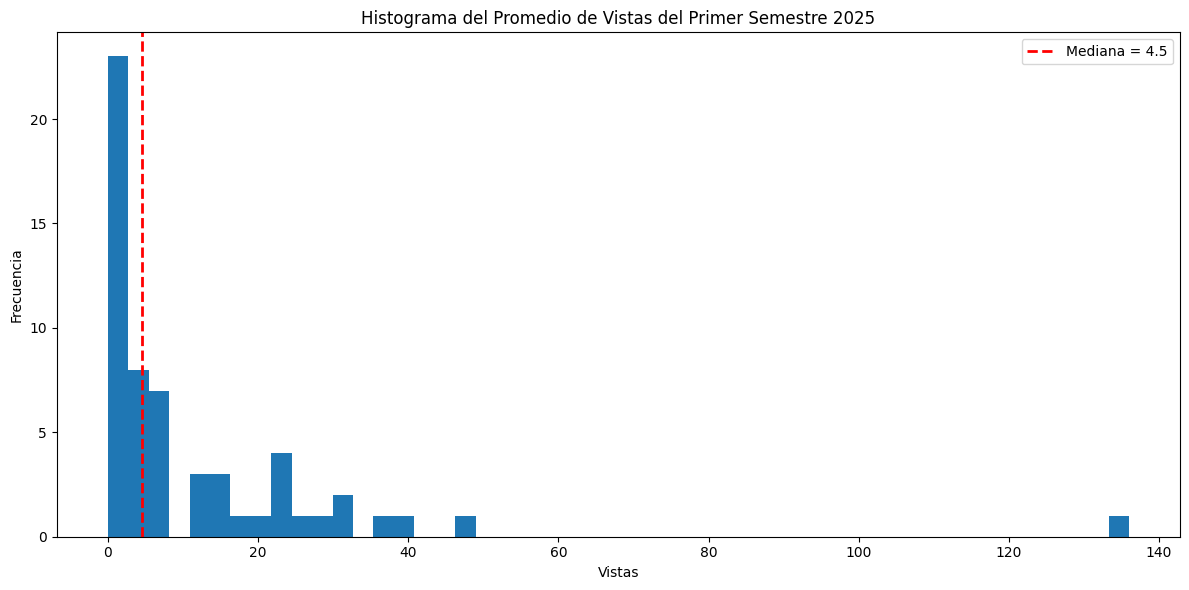

In [92]:
plt.figure(figsize=(12,6))
plt.hist(total_vistas,bins=50)

# Añadir mediana
plt.axvline(x=mediana_vistas,color='red',linestyle='--',linewidth=2,label=f'Mediana = {mediana_vistas:.1f}')

# Estética
plt.title('Histograma del Promedio de Vistas del Primer Semestre 2025')
plt.xlabel('Vistas')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()


In [93]:
total_dashboards_debajo_mediana = len(total_vistas[total_vistas>mediana_vistas])

print('Total de Dashboards por debajo de la Mediana:',total_dashboards_debajo_mediana)
print('% de Dashboards por debajo de la Mediana:',total_dashboards_debajo_mediana/len(total_vistas))

Total de Dashboards por debajo de la Mediana: 29
% de Dashboards por debajo de la Mediana: 0.5


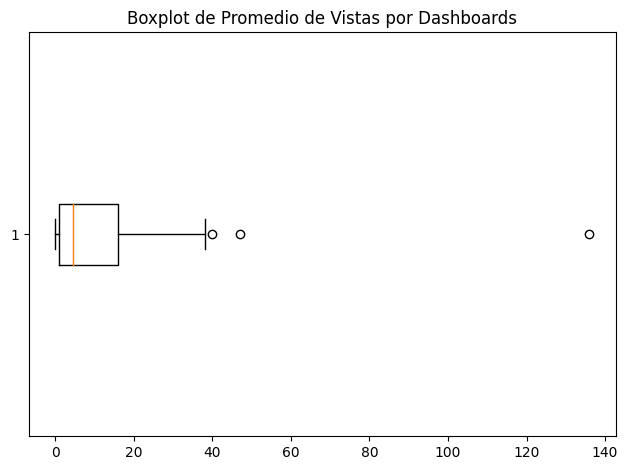

In [94]:
plt.boxplot(total_vistas,vert=False)
plt.title('Boxplot de Promedio de Vistas por Dashboards')
plt.tight_layout()
plt.show()

In [95]:
def calcular_outliers(col: pd.Series):

    """
    Función para identificar los Outliers de una variable numérica
    Args:
    - col: Es la serie de pandas que representa a una variable numérica
    """

    print('Columna:',col.name,'\n')
    
    # Selección de 1er y 3er cuartil
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)

    # Rango Intercuartil
    IQR = Q3 - Q1

    # Definir whiskers
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    print('IQR:',IQR)
    print('Lower Whisker:',lower_whisker)
    print('Upper Whisker:',upper_whisker)

    # Calcular valores Outliers
    outliers = col[(col<lower_whisker) | (col>upper_whisker)]

    # Identificar Dashboards con número de vistas atípicas
    print(df[['Dashboard',col.name]][df[col.name].isin(outliers)].sort_values(by=col.name,ascending=False))


In [96]:
calcular_outliers(df['prom_vistas_1_sem_2025'])

Columna: prom_vistas_1_sem_2025 

IQR: 15.0
Lower Whisker: -21.5
Upper Whisker: 38.5
                               Dashboard  prom_vistas_1_sem_2025
44  CSC_PTP Gestión del Proceso OC-OS TI                   136.0
3                 CSC_SLA_Administración                    47.0
0              CSC_ADM_Servicio de Taxis                    40.0


### 3.6. Análisis de Usuarios con Acceso

Mediana de Usuarios con Accesos al Dashboard; 38.5


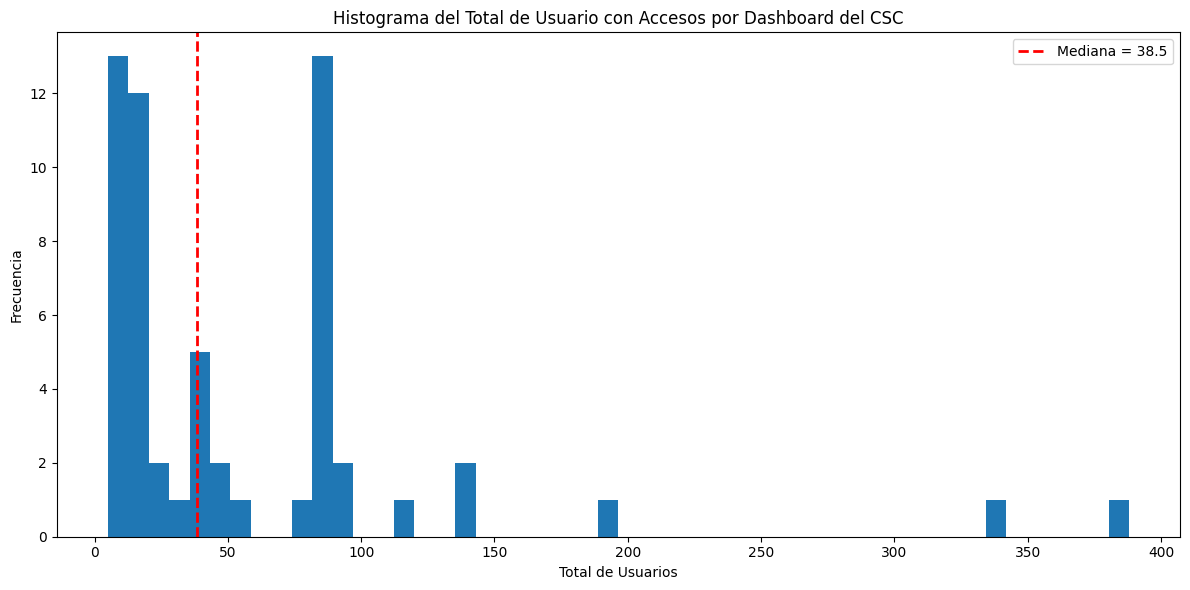

In [97]:
mediana_usuarios = df['Usuarios'].median()

print('Mediana de Usuarios con Accesos al Dashboard;', mediana_usuarios)

plt.figure(figsize=(12,6))
plt.hist(df['Usuarios'],bins=50)

# Añadir mediana
plt.axvline(x=mediana_usuarios,color='red',linestyle='--',linewidth=2,label=f'Mediana = {mediana_usuarios:.1f}')

# Estética
plt.title('Histograma del Total de Usuario con Accesos por Dashboard del CSC')
plt.xlabel('Total de Usuarios')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()

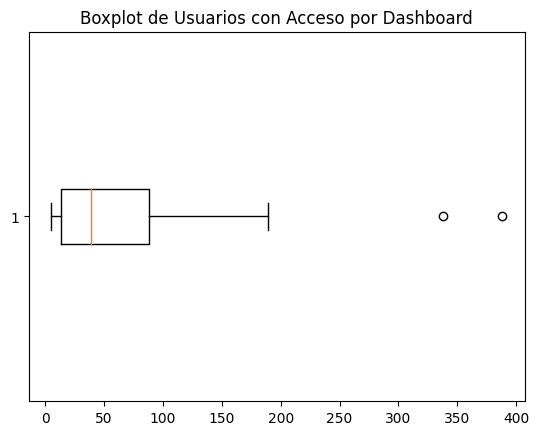

In [98]:
plt.boxplot(df['Usuarios'],vert=False)
plt.title('Boxplot de Usuarios con Acceso por Dashboard')
plt.show()

In [99]:
# Total de Dashboards con menos usuarios con accesos a la mediana
len(df['Usuarios'][df['Usuarios']<mediana_usuarios])

29

In [100]:
calcular_outliers(df['Usuarios'])

Columna: Usuarios 

IQR: 75.0
Lower Whisker: -99.5
Upper Whisker: 200.5
                                        Dashboard  Usuarios
47  CSC_PTP_Dashboard Homologación de Proveedores       388
0                       CSC_ADM_Servicio de Taxis       338


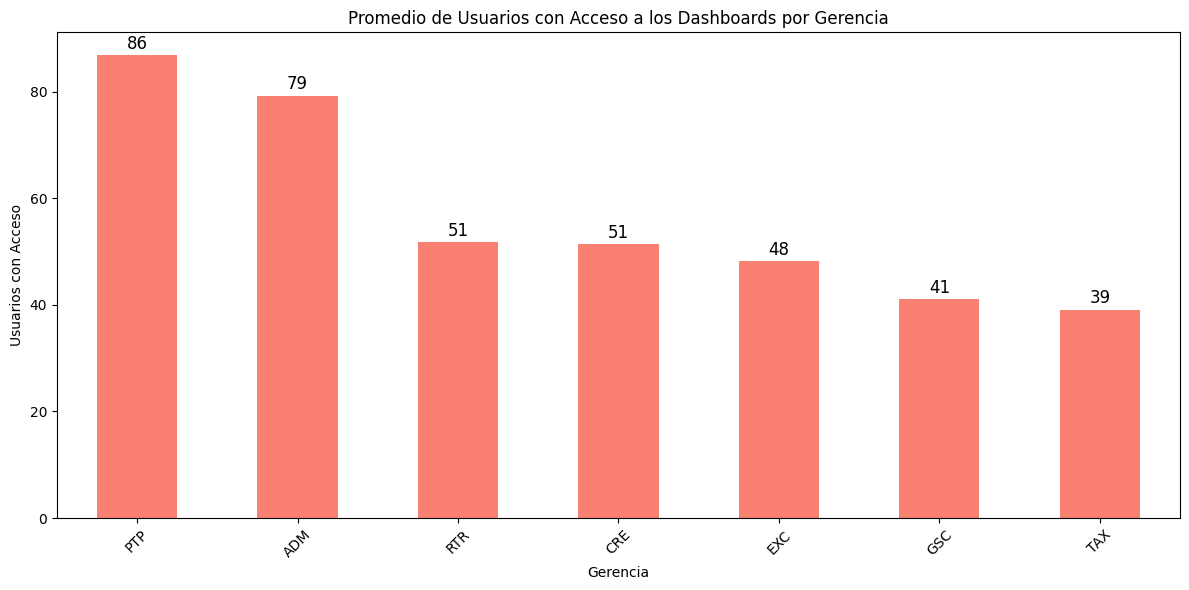

In [101]:
# Agrupar total de Dashboards por Gerencia en orden descendente
df_usuarios_por_gerencia = df.groupby(['Gerencia'])['Usuarios'].mean().sort_values(ascending=False)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 6))

# Hacer gráfico de barras y guardar el objeto gráfico
bars = df_usuarios_por_gerencia.plot(kind='bar', ax=ax, color='salmon')

# Añadir los números encima de cada barra
for i, value in enumerate(df_usuarios_por_gerencia.values):
    ax.text(i, value + 0.5, str(int(value)), ha='center', va='bottom', fontsize=12)

# Ajustes del gráfico
ax.set_title('Promedio de Usuarios con Acceso a los Dashboards por Gerencia')
ax.set_ylabel('Usuarios con Acceso')
ax.set_xlabel('Gerencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

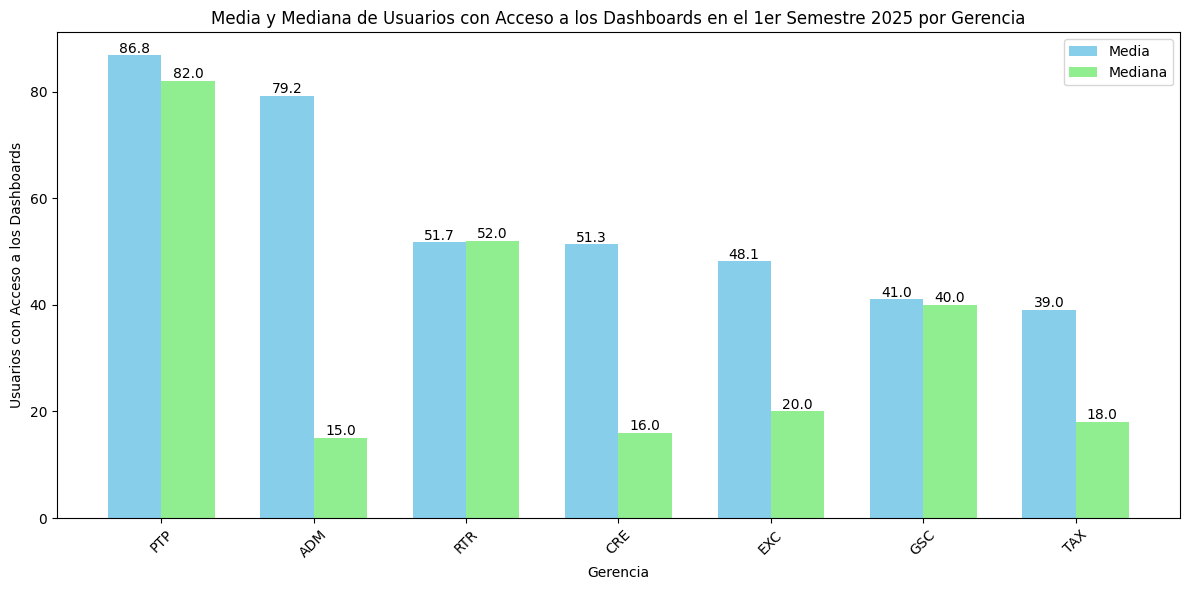

In [102]:
# Calcular media y mediana por Gerencia
media_por_gerencia = df.groupby('Gerencia')['Usuarios'].mean().sort_values(ascending=False)
mediana_por_gerencia = df.groupby('Gerencia')['Usuarios'].median()

# Asegurar que están en el mismo orden
gerencias = media_por_gerencia.index
media_vals = media_por_gerencia.values
mediana_vals = mediana_por_gerencia[gerencias].values

# Posiciones para las barras
x = np.arange(len(gerencias))  # posiciones de cada gerencia
width = 0.35  # ancho de cada barra

# Crear gráfico
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, media_vals, width, label='Media', color='skyblue')
bars2 = ax.bar(x + width/2, mediana_vals, width, label='Mediana', color='lightgreen')

# Añadir etiquetas encima de cada barra
for i in range(len(x)):
    ax.text(x[i] - width/2, media_vals[i] + 0.5, f'{media_vals[i]:.1f}', ha='center', fontsize=10)
    ax.text(x[i] + width/2, mediana_vals[i] + 0.5, f'{mediana_vals[i]:.1f}', ha='center', fontsize=10)

# Ajustes del gráfico
ax.set_title('Media y Mediana de Usuarios con Acceso a los Dashboards en el 1er Semestre 2025 por Gerencia')
ax.set_ylabel('Usuarios con Acceso a los Dashboards')
ax.set_xlabel('Gerencia')
ax.set_xticks(x)
ax.set_xticklabels(gerencias, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

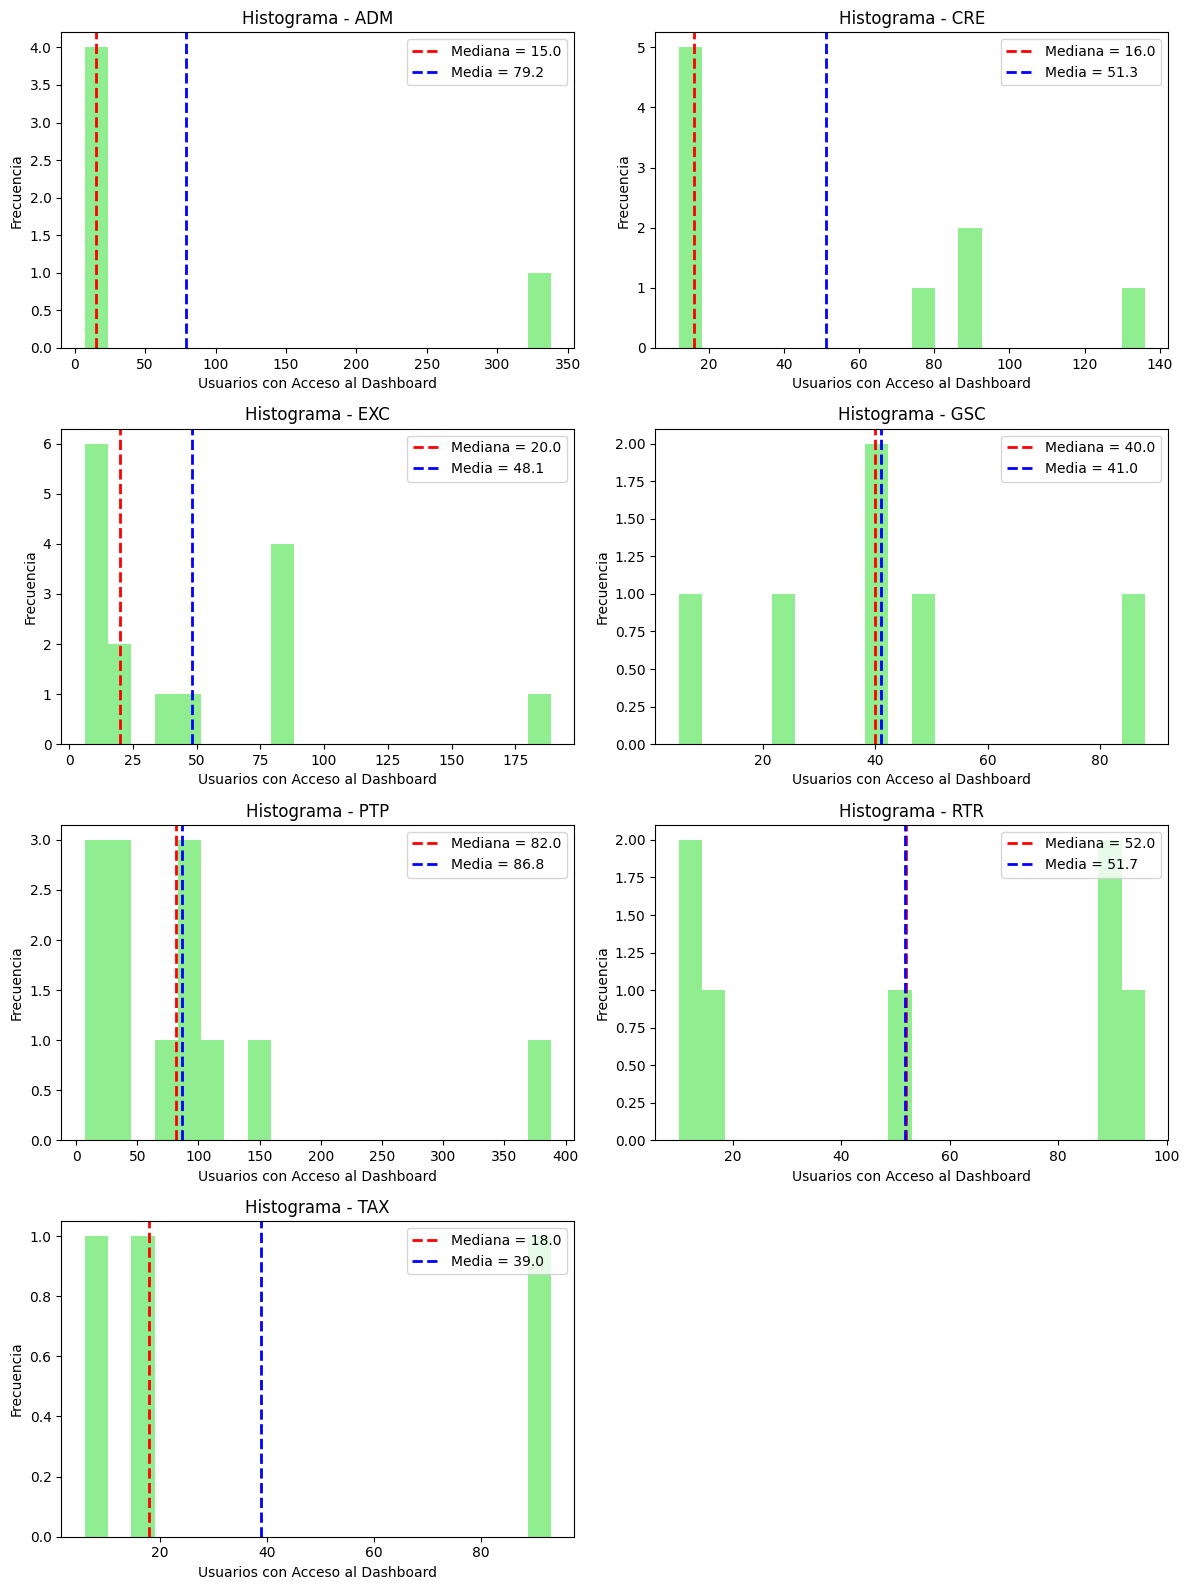

In [103]:
# Obtener lista única de gerencias
gerencias = df['Gerencia'].unique()
num_gerencias = len(gerencias)

# Configurar subplots: 2 columnas, suficientes filas
cols = 2
rows = (num_gerencias + 1) // cols  # redondear hacia arriba, ya que son 7 gerencias

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()  # para acceder como una lista plana

# Crear un histograma por gerencia
for i, gerencia in enumerate(gerencias):
    ax = axes[i]
    datos = df[df['Gerencia'] == gerencia]['Usuarios']
    mediana_i = datos.median()
    media_i = datos.mean()

    # Configurar valores
    ax.hist(datos, bins=20, color='lightgreen')
    ax.axvline(x=mediana_i,color='red',linestyle='--',linewidth=2,label=f'Mediana = {mediana_i:.1f}')
    ax.axvline(x=media_i,color='blue',linestyle='--',linewidth=2,label=f'Media = {media_i:.1f}')
    ax.set_title(f'Histograma - {gerencia}')
    ax.legend()
    ax.set_xlabel('Usuarios con Acceso al Dashboard')
    ax.set_ylabel('Frecuencia')

# Si sobran subplots vacíos (en este caso, 1), los ocultamos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

En esta gráfica se puede ver lo siguiente:

- **La Gerencia de Administración (ADM)** tiene 4 dashboards de los cuales tienen acceso 15 personas. No obstante, tienen un Dashboard con 338 usuarios con acceso, lo que puede distorsionar nuestra medición.
- **La Gerencia de Tesorería Operativa y PTP (PTP)** cuenta con el Dashboard con más usuarios con permiso (Homologación de Proveedores). No obstante, cuentan con dashboards con una cantidad considerable de usuarios con acceso, por lo que la media y la mediana no tienen mucha diferencia.
- La mitad de los dashboards de la **La Gerencia de Créditos BO y Cobranzas (CRE)** tiene 16 usuarios con acceso.
- La mitad de los dashboards de la **Gerencia de Excelencia Operativa (EXC)** tiene 20 usuarios con acceso, o menos. Además, cuenta con un dashboard con más de 175 usuarios con acceso.
- **La Gerencia de Operación Tributaria (TAX)** cuenta con dos dashboard con 20 usuarios con acceso (o menos) y un dashboard con más de 85 usuarios.
- Las demás gerencias (GSC y RTR) cuentan con una media y mediana de usuarios con acceso similar.

**Conclusiones**

Se puede apreciar en las gráficas que:

- Aproximadamente la mitad de dashboards (29) están por debajo de la mediana de usuarios con acceso a los dashboards (38.5).
- Hay dos Dashboards en todo el CSC que tiene una cantidad de usuarios con accesos muy por encima de la normalidad, lo que puede afectar al cálculo de la medición. Estos son:

    - El Dashboard de Homologación de Proveedores con 388 usuarios con acceso
    - El Dashboard de Servicios de Taxis con 338 usuarios con acceso

- Los dashboards restantes están en un límite de 0 a 200 usuarios con acceso.
- La Gerencia de PTP es la gerencia que tiene la mayor cantidad de usuarios con acceso a sus dashboard, en promedio. Eso se puede explicar debido a:
     
     - La cantidad de usuarios que hay dentro de la gerencia.
     - La cantidad de clientes internos que maneja PTP en sus distintos procesos (Registros de Facturas, Liquidación de Transportes, Creación de HES de TI, etc.)

- Por otro lado, la Gerencia que tiene la menor cantidad de usuarios con acceso en promedio es la Gerencia de Operación Tributaria.
- Es importante realizar este análisis porque **la medición de la usabilidad va a tomar la cantidad total de usuarios con acceso a los dashboards como variable**

### 4. Propuesta de Cálculo de Usabilidad

$$
{\text{Umbral de Usabilidad}} = {\text{Factor de Frecuencia}} \times {\text{Total de Usuarios con Acceso}}  \times 0.10
$$ 

Donde:

- ${\text{Factor de Frecuencia}}$: Es un coeficiente que va a variar en función a la frecuencia de actualización del Dashboard. Este factor nos ayuda a comparar las distintas frecuencias de manera uniforme, tomando como referencia los últimos seis (6) Meses 

- ${\text{Total de Usuarios con Acceso}}$: Es el número de usuarios que tienen acceso de visualización al Dashboard publicado en Power BI Viewer

- $0.10$: Es una constante que nos ayuda a definir un umbral como un porcentaje del número de vistas.

### 4.1. Factor de Frecuencia

Como primera variable, tomamos en cuenta la frecuencia de actualización del Dashboard. Esta variable será proporcionada por el usuario cuando registre su solicitud de publicación del Dashboards.

- La **actualización diarias o semanales** dependerá de la fuente de datos. Si es una fuente de datos que se actualiza al momento, o con frecuencias muy altas como Tablas de GCP o Listas de Sharepoint, entonces es más probable que se actualice de manera diaria o semanal.

- Actualizaciones mensuales (los casos más frecuentes) se dan porque muchos indicadores del CSC se miden bajo periodo cerrado. 

- Actualmente no se tienen indicadores con frecuencias superiores (bimestrales, trimestrales, etc.), pero tendrá un factor de equivalencia que se mostrará a continuación.

Por lo tanto, la lógica detrás de esta variable nos indica:

- *"Si un dashboard se actualiza una vez al mes, entonces un usuario debería ingresar AL MENOS una vez al mes."*
- *"Si un dashboard se actualiza una vez por semana, entonces un usuario debería ingresar AL MENOS una vez por semana."*

|Frecuencia|Vistas por Mes| Vistas por 6 Meses|
|-----|----|----|
|Diaria (1)|4|24|
|Semanal|4|24|
|A demanda (2)|1|6|
|Mensual|1|6|
|Bimestral|0.5|3|
|Trimestral|0.33|2|
|Semestral|0.17|1|
|Anual|0.08|0.5|

- (1) Se probó, para la **frecuencia diaria** con 22 días al mes bajo la lógica (*"Si un dashboard se actualiza una vez al día, entonces un usuario debería ingresar AL MENOS veintidós veces al mes."*). 
- No obstante, este número no es realista y los umbrales de vistas son demasiado altos.
- Por lo tanto, para la **frecuencia diaria** se calculará bajo la lógica semanal. Lo que nos ha dado números más cercanos a la realidad.
- (2) La frecuencia **a demanda** implica que el Dashboard de actualizará a petición del área usuaria. Se les hará la consulta de manera periódica. Esta casuística se manejó inicialmente con la gerencia de Operación Tributaria. 
- Para estandarizar las consultas, lo manejaremos con una frecuencia mensual (1 vista al mes y 6 vistas por 6 meses)

### 4.2. Total de Usuarios con Acceso

Se toma en consideración la variable **Total de Usuarios con Acceso** bajo la siguiente lógica.

- *Se espera que la cantidad de vistas que reciba el Dashboard vaya en proporción a la cantidad de audiencia disponible*
- *Si para un dashboard se gestionaron 150 accesos, el tener solo 1 vista al mes no justifica el mantenimiento del Dashboard*

### 4.3. Constante

No obstante, en la práctica se entiende que el 100% de usuarios no visualizarán el Dashboard de manera constante, por lo que la constante sirve para poder indicar *¿Qué porcentaje de usuarios se necesita para determinar el umbral de vistas por Dashboard?*

Se eligió el valor 0.10 debido a que es el valor que se mejor se ajusta a la realidad. A continuación, se muestra la aplicación de la fórmula con otros valores.

|Constante|% de Usabilidad|
|---|---|
|0.05|0.53|
|**0.1**|**0.48**|
|0.15|0.43|
|0.2|0.38|
|0.25|0.31|
|0.3|0.26|

El valor que más se acerca a un valor del 50% fue, precisamente, el de 0.10. Además, se constrastaron los Dashboards marcados como activos e inactivos de manera individual, para apoyarse en el análisis empírico.

- Valores menos a 0.10 son muy permisivos en el umbral de visualizaciones.
- Valores superiores a 0.10 suelen marcar como no activos a dashboards que sí tienen cierta cantidad de visualizaciones.

### 4.4. Lógica de la Fórmula de Umbral de Usabilidad

Finalmente, la lógica de la propuesta de medición indica:

*Para determinar mi umbral de actividad para determinar si un dashboard es activo o no, es necesario que al menos el 10% de los Usuarios con Acceso al Dashboard hayan visto 1 vez el dashboard, según la frecuencia de actualización*

Por ejemplo:

Si tenemos un dashboard mensual con veinte (20) vistas en los últimos 6 meses y 50 usuarios con acceso, se esperaría 

$$
{\text{Umbral de Usabilidad}} = 6 \times 50 \times 0.10 = 30 {\text{ vistas en los últimos 6 meses}}
$$ 

Por lo que veinte (20) vistas en 6 meses no justifica el mantenimiento de ese Dashboards, para lo cual, el equipo de Analytics CSC deberá deplegar planes de acción.

## 5. Aplicación de la Fórmula de Usabilidad

### 5.1. Creación de Umbral de Usabilidad por Dashboard

In [104]:
dict_frecuencia = {
    'Mensual': 1,
    'Semanal': 4, # 4 semanas en un mes
    'A demanda': 1, # Se va a calcular como mensual
    'Diaria': 4, # Solo se van a contar días hábiles
    'Bimestral': 0.5, # 1/2 meses
    'Trimestral': 0.33, # 1/3 meses
    'Semestral': 0.17, # 1/6 meses
    'Anual': 0.08 # 1/12 meses
}

def umbral_usabilidad(total_usuarios,frecuencia,coef=0.10):

    """
    Función para determinar el umbral de usabilidad por dashboards.
    Args:
    - Total Usuarios
    - Frecuencia de Actualización
    - Coeficiente
    """

    # Calcular para definir el total de vistas de los últimos 6 meses
    factor_frecuencia = dict_frecuencia[frecuencia] * 6

    return round(math.ceil(coef * total_usuarios) * factor_frecuencia,0)


In [105]:
# Aplicar función de umbral de vistas
df['umbral_vistas'] = df.apply(lambda row: umbral_usabilidad(total_usuarios=row['Usuarios'],
                                                             frecuencia=row['Frecuencia']),
                                                             axis=1)

# Añadir flag de "es activo" siempre y cuando el total de vistas sea mayor o igual al umbral seleccionado
df['es_activo'] = np.where(df['total_vistas_1_sem_2025'] >= df['umbral_vistas'],1,0)

df[['Dashboard','Usuarios','Frecuencia','total_vistas_1_sem_2025','umbral_vistas','es_activo']].sort_values('total_vistas_1_sem_2025',ascending=False).head(10)

,Dashboard,Usuarios,Frecuencia,total_vistas_1_sem_2025,umbral_vistas,es_activo
44,CSC_PTP Gestión del Proceso OC-OS TI,141,Diaria,815.0,360,1
3,CSC_SLA_Administración,15,Mensual,282.0,12,1
0,CSC_ADM_Servicio de Taxis,338,Mensual,240.0,204,1
45,CSC_PTP Control de Liquidación de Transportes,39,Mensual,227.0,24,1
31,CSC_SLA_Servicios al Colaborador,39,Mensual,185.0,24,1
32,CSC_SLA_Servicios al Colaborador v4 (Vacaciones),49,Diaria,178.0,120,1
43,CSC_PTP Gestión de Creación de OC-OS - TI,113,Mensual,174.0,72,1
51,CSC_SLA_RTR,52,Mensual,147.0,36,1
2,CSC_ADM_Control presupuestal,21,Mensual,146.0,18,1
7,CSC_TES_Saldos a favor,136,Semanal,131.0,336,0


In [106]:
total_dashboards_activos = len(df['es_activo'][df['es_activo']==1])
total_dashboards = len(df)

print('Total de Dashboards Activos:',total_dashboards_activos)
print('Total de Dashboards:',total_dashboards)
print('% de Usabilidad de Dashboards del CSC:', round(total_dashboards_activos / total_dashboards,2))

Total de Dashboards Activos: 28
Total de Dashboards: 58
% de Usabilidad de Dashboards del CSC: 0.48


### 5.2. Análisis de Variabilidad por Constantes

En este paso, buscamos medir el **% de usabilidad global** probando con distintas constantes para evaluar rangos ideales.

In [107]:
# Generamos una copia del Dataframe anterior para no modificarlo
df_prueba = df.copy()

In [108]:
valores = [0.05,0.1,0.15,0.2,0.25,0.3]

for valor in valores:

    # Aplicar función de umbral de vistas
    df_prueba['umbral_vistas'] = df_prueba.apply(lambda row: umbral_usabilidad(total_usuarios=row['Usuarios'],
                                                                frecuencia=row['Frecuencia'],
                                                                coef=valor),
                                                                axis=1)

    # Añadir flag de "es activo" siempre y cuando el total de vistas sea mayor o igual al umbral seleccionado
    df_prueba['es_activo'] = np.where(df_prueba['total_vistas_1_sem_2025'] >= df_prueba['umbral_vistas'],1,0)

    total_dashboards_activos = len(df_prueba['es_activo'][df_prueba['es_activo']==1])
    total_dashboards = len(df_prueba)
    print(f'% de Usabilidad - Valor {valor}:', round(total_dashboards_activos / total_dashboards,2))


% de Usabilidad - Valor 0.05: 0.53
% de Usabilidad - Valor 0.1: 0.48
% de Usabilidad - Valor 0.15: 0.43
% de Usabilidad - Valor 0.2: 0.38
% de Usabilidad - Valor 0.25: 0.31
% de Usabilidad - Valor 0.3: 0.26


In [109]:
df_diario = df[df['Frecuencia']=='Diaria'].sort_values('total_vistas_1_sem_2025',ascending=False)
df_diario.to_excel('Prueba_diarios1.xlsx')

In [110]:
cols_excel = ['Gerencia','Dashboard','Usuarios','Usuarios Activos','Frecuencia',
              'total_vistas_1_sem_2025','prom_vistas_1_sem_2025',
              'umbral_vistas','es_activo']

df_excel = df[cols_excel]
df_excel['Factor_Frecuencia'] = round(df_excel['Frecuencia'].map(dict_frecuencia).astype(float) * 6,0)

df_excel.sort_values('total_vistas_1_sem_2025',ascending=False).to_excel('Total de vistas con umbrales.xlsx',index=False)

### 5.3. Cálculo de Information Value

En esta etapa, lo que se busca es determinar qué tanto impacto tienen las variables en la actividad de un dashboard ("es_activo")

In [113]:
def calcular_iv(col,df=df,target='es_activo',lista_cat=None,generar_col=False):

    """
    Calcula el IV de una columna.
    
    Args:
        col (str): Columna a evaluar.
        df (DataFrame): DataFrame que contiene la columna y el target.
        target (str): Nombre de la columna objetivo.
        lista_cat (dict): Opcional. Son bins personalizados que permiten haer una mejor categorización de los datos, si es que los valores por defecto no son satisfactorios

    """

    if lista_cat is None:
        bins = sc.woebin(df[[col, target]], y=target)
    else:
        bins = sc.woebin(df[[col, target]], y=target, breaks_list={col: lista_cat})
        
    print(bins[col])
    iv = bins[col]['total_iv'].iloc[0]
    print(f"\nIV de la columna {col}: {iv}")
    
    # Graficar los bins
    plt.figure(figsize=(16,6))
    sc.woebin_plot(bins[col])
    plt.show()

#### 5.3.1. Frecuencia de Actualización

[INFO] creating woe binning ...
     variable        bin  count  count_distr  good  bad   badprob       woe  \
0  Frecuencia    Mensual     43     0.741379    20   23  0.534884  0.177118   
1  Frecuencia    Semanal      3     0.051724     2    1  0.333333 -0.655791   
2  Frecuencia     Diaria     10     0.172414     6    4  0.400000 -0.368109   
3  Frecuencia  A demanda      2     0.034483     2    0  0.000000 -0.761152   

     bin_iv  total_iv     breaks  is_special_values  
0  0.022880   0.09362    Mensual              False  
1  0.021028   0.09362    Semanal              False  
2  0.022672   0.09362     Diaria              False  
3  0.027040   0.09362  A demanda              False  

IV de la columna Frecuencia: 0.09362018798393036


<Figure size 1600x600 with 0 Axes>

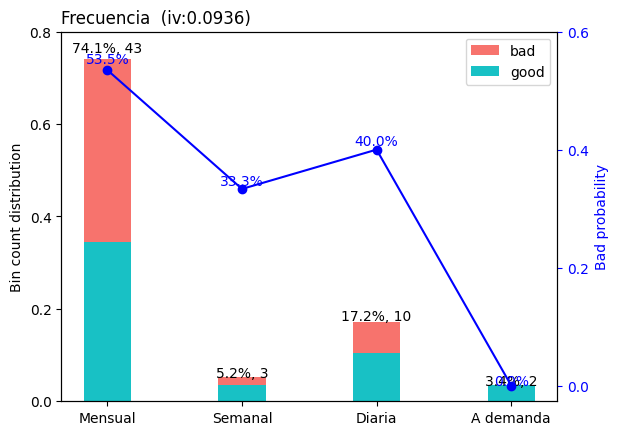

In [115]:
calcular_iv('Frecuencia',lista_cat=df['Frecuencia'].unique())

De esta gráfica podemos ver que la frecuencia de actualización diaria influye considerablemente en el nivel de actividad de un dashboard

- Esto puede explicarse debido a que los usuarios están más interesados en revisar constantemente un dashboard que se actualiza de manera más frecuente.

- Por otro lado, los dashboard con frecuencia mensual, en algunos casos, requiere de que el usuario suba la información a un sharepoint o ruta compartida, lo que le añade manualidad al proceso.

- Además, la revisión de los indicadores que se hacen sobre periodo cerrado se validan en reuniones o comités específicos y de ahí se revisan de manera puntual hasta que se cierre el siguiente periodo.

#### 5.3.2. Total de Usuarios con Acceso

[INFO] creating woe binning ...
   variable          bin  count  count_distr  good  bad   badprob       woe  \
0  Usuarios  [-inf,10.0)      8     0.137931     6    2  0.250000 -1.029619   
1  Usuarios  [10.0,40.0)     23     0.396552     5   18  0.782609  1.349927   
2  Usuarios  [40.0,85.0)      7     0.120690     3    4  0.571429  0.356675   
3  Usuarios  [85.0,90.0)     12     0.206897    11    1  0.083333 -2.328902   
4  Usuarios   [90.0,inf)      8     0.137931     5    3  0.375000 -0.441833   

     bin_iv  total_iv breaks  is_special_values  
0  0.132380  1.587543   10.0              False  
1  0.642822  1.587543   40.0              False  
2  0.015286  1.587543   85.0              False  
3  0.770756  1.587543   90.0              False  
4  0.026300  1.587543    inf              False  

IV de la columna Usuarios: 1.5875433178517768


<Figure size 1600x600 with 0 Axes>

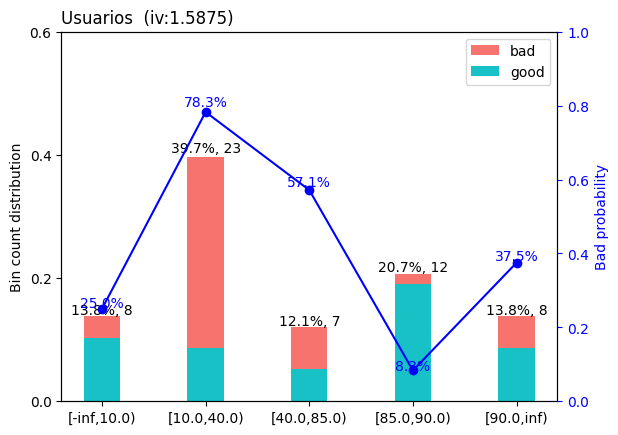

In [117]:
calcular_iv('Usuarios')

De esta gráfica no podemos sacar conclusiones interpretables acerca de la influencia de la cantidad de usuarios respecto al nivel de usabilidad de un dashboard

#### 5.3.3. Es Chapter

[INFO] creating woe binning ...
     variable         bin  count  count_distr  good  bad  badprob       woe  \
0  Es_Chapter  [-inf,1.0)     50     0.862069    25   25    0.500  0.068993   
1  Es_Chapter   [1.0,inf)      8     0.137931     5    3    0.375 -0.441833   

     bin_iv  total_iv breaks  is_special_values  
0  0.004107  0.030406    1.0              False  
1  0.026300  0.030406    inf              False  

IV de la columna Es_Chapter: 0.03040628712892801


<Figure size 1600x600 with 0 Axes>

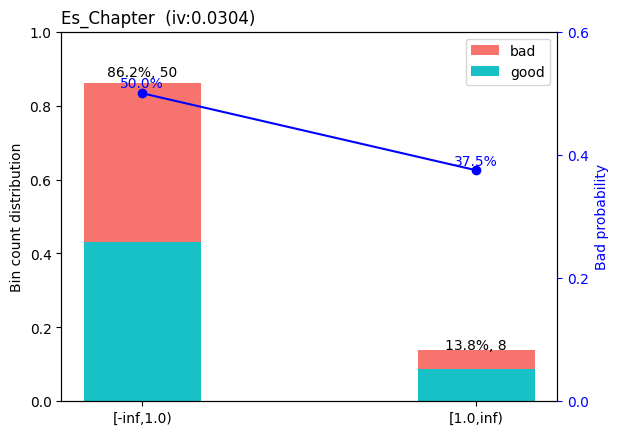

In [122]:
calcular_iv('Es_Chapter')

In [124]:
print(f"Total de Dashboards del Chapter Data & Analytics: {len(df[df['Es_Chapter'] == 1])}")

Total de Dashboards del Chapter Data & Analytics: 8


Se puede apreciar que hay una ligera probabilidad que un Dashboard quede en estado de inactividad si viene de una iniciativa del Chapter.

No obstante, los dashboard creados por iniciativas de Chapter son 8, por lo que la muestra es relativamente pequeña y la diferencia entre ambas probabilidades no es muy alta.

#### 5.3.4. Fuente de Datos - GCP

[INFO] creating woe binning ...
          variable         bin  count  count_distr  good  bad   badprob  \
0  Fuente_BigQuery  [-inf,1.0)     52     0.896552    29   23  0.442308   
1  Fuente_BigQuery   [1.0,inf)      6     0.103448     1    5  0.833333   

        woe    bin_iv  total_iv breaks  is_special_values  
0 -0.162809  0.023646  0.267418    1.0              False  
1  1.678431  0.243772  0.267418    inf              False  

IV de la columna Fuente_BigQuery: 0.26741812170470697


<Figure size 1600x600 with 0 Axes>

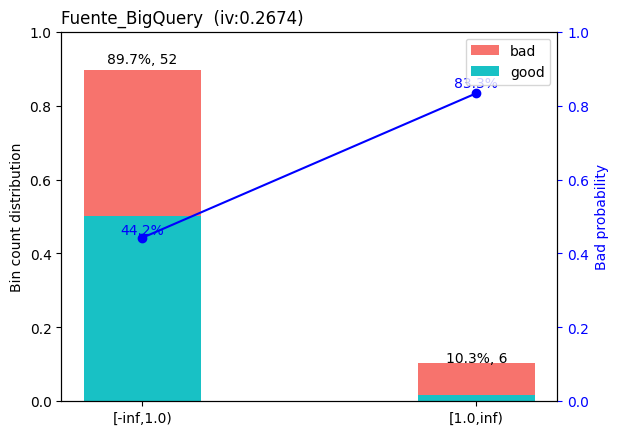

In [119]:
calcular_iv('Fuente_BigQuery')

In [121]:
print(f"Total de Dashboards: {len(df[df['Fuente_BigQuery'] == 1])}")


Total de Dashboards: 6


La evidencia nos indica que es más probable que un dashboard caiga en inactividad si cuenta con una fuente de datos de GCP.

Actualmente no contamos con una muestra significativa para determinar si el uso de Dashboards con conexión a GCP tiene un impacto significativo en la usabilidad del Dashboards. 

Algunos de estos dashboard están publicados. No obstante, queda pendiente revisar algunas observaciones, por lo que su uso aún no es del todo extendido.

Se sugiere esperar a que se estabilice el uso de los Dashboard con conexión a GCP para tomar mejores conclusiones.

## 6. Conclusiones y Recomendaciones

De este análisis, podemos concluir lo siguiente.

- El equipo de Analytics CSC deberá monitorear la usabilidad de cada dashboard de manera individual, para evitar el uso ineficiente del servicio de Power BI Viewer.
- Se buscará tener un mayor control de los usuarios activos que tengan acceso a los Dashboards, debido a que esto tiene un impacto en la usabilidad de los Dashboards.
- Se recomienda analizar detalladamente a los dashboard con menos vistas y proponer, bien su baja del servicio de Power BI Viewer, o bien la unificación con otros dashboards relacionados, buscando mantener algún indicador que la Gerencia considere relevante mantener.
- Se recomienda que, en adelante, impulsar a que los dashboard tengan conexiones directas a GCP para evitar la manualidad y tener frecuencias más altas de actualización de los Dashboards, lo que puede contribuir a aumentar la usabilidad de los Dashboards.